<a href="https://colab.research.google.com/github/abhi220501/EE769-Cource-Project/blob/main/Soyabean_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/dataset_defonet.zip

In [ ]:
!unzip -q /content/drive/MyDrive/dataset_defo.zip

warning [/content/drive/MyDrive/dataset_defo.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [/content/drive/MyDrive/dataset_defo.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #97402).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


In [ ]:
pip install torchsampler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchsampler import ImbalancedDatasetSampler

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],sampler=ImbalancedDatasetSampler(image_datasets[x]), batch_size=4, 
                                              num_workers=2)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

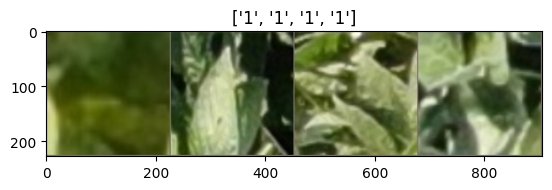

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
from collections import OrderedDict

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_ftrs, 1024)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(1024, 512)),
    ('relu', nn.ReLU()),
    ('fc3', nn.Linear(512, 256)),
    ('relu', nn.ReLU()),
    ('fc4', nn.Linear(256,2))    
]))


model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=2, gamma=0.05)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 68.4MB/s]


In [ ]:
print(num_ftrs)

2048


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=6)

Epoch 0/5
----------
train Loss: 0.5489 Acc: 0.6928
test Loss: 0.4401 Acc: 0.7708

Epoch 1/5
----------
train Loss: 0.5135 Acc: 0.7206
test Loss: 0.4193 Acc: 0.7839

Epoch 2/5
----------
train Loss: 0.4948 Acc: 0.7343
test Loss: 0.4227 Acc: 0.7850

Epoch 3/5
----------
train Loss: 0.4923 Acc: 0.7358
test Loss: 0.4339 Acc: 0.7768

Epoch 4/5
----------
train Loss: 0.4905 Acc: 0.7354
test Loss: 0.4156 Acc: 0.7872

Epoch 5/5
----------
train Loss: 0.4917 Acc: 0.7329
test Loss: 0.4113 Acc: 0.7826

Training complete in 57m 49s
Best val Acc: 0.787232


In [ ]:
loaded_checkpoint = torch.load('/content/drive/MyDrive/Saved Models/soyabean_resnet50_6_withIDS.pth')
model_conv.load_state_dict(loaded_checkpoint['state_dict'])
optimizer_conv.load_state_dict(loaded_checkpoint['optimizer_dict'])

In [ ]:
#7-20 epochs
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=14)

Epoch 0/13
----------
train Loss: 0.4894 Acc: 0.7364
test Loss: 0.4045 Acc: 0.7965

Epoch 1/13
----------
train Loss: 0.4907 Acc: 0.7356
test Loss: 0.4068 Acc: 0.7971

Epoch 2/13
----------
train Loss: 0.4901 Acc: 0.7374
test Loss: 0.4148 Acc: 0.7909

Epoch 3/13
----------
train Loss: 0.4892 Acc: 0.7367
test Loss: 0.4134 Acc: 0.7902

Epoch 4/13
----------
train Loss: 0.4903 Acc: 0.7351
test Loss: 0.4293 Acc: 0.7914

Epoch 5/13
----------
train Loss: 0.4910 Acc: 0.7356
test Loss: 0.4069 Acc: 0.8001

Epoch 6/13
----------
train Loss: 0.4916 Acc: 0.7354
test Loss: 0.4179 Acc: 0.7892

Epoch 7/13
----------
train Loss: 0.4882 Acc: 0.7379
test Loss: 0.4098 Acc: 0.7975

Epoch 8/13
----------
train Loss: 0.4920 Acc: 0.7334
test Loss: 0.4064 Acc: 0.7863

Epoch 9/13
----------
train Loss: 0.4904 Acc: 0.7372
test Loss: 0.4040 Acc: 0.7946

Epoch 10/13
----------
train Loss: 0.4888 Acc: 0.7358
test Loss: 0.4161 Acc: 0.7873

Epoch 11/13
----------
train Loss: 0.4901 Acc: 0.7339
test Loss: 0.4106 Acc

In [ ]:
model_conv.class_to_idx = dataloaders['train'].dataset.class_to_idx
model_conv.epochs = 20
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 2,
                  'state_dict': model_conv.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer_conv.state_dict(),
                  'class_to_idx': model_conv.class_to_idx,
                  'epoch': model_conv.epochs}
torch.save(checkpoint, '/content/drive/MyDrive/Saved Models/soyabean_resnet50_20_withIDS.pth')

In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
from collections import OrderedDict

model_ft.fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_ftrs, 1024)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(1024, 512)),
    ('relu', nn.ReLU()),
    ('fc3', nn.Linear(512, 256)),
    ('relu', nn.ReLU()),
    ('fc4', nn.Linear(256,2))    
]))


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.05)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 298MB/s]


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=6)

Epoch 0/5
----------
train Loss: 0.4547 Acc: 0.7592
test Loss: 0.3962 Acc: 0.7990

Epoch 1/5
----------
train Loss: 0.4095 Acc: 0.7868
test Loss: 0.3524 Acc: 0.8316

Epoch 2/5
----------
train Loss: 0.3763 Acc: 0.8060
test Loss: 0.3284 Acc: 0.8516

Epoch 3/5
----------
train Loss: 0.3725 Acc: 0.8096
test Loss: 0.3192 Acc: 0.8503

Epoch 4/5
----------
train Loss: 0.3679 Acc: 0.8125
test Loss: 0.3149 Acc: 0.8584

Epoch 5/5
----------
train Loss: 0.3655 Acc: 0.8128
test Loss: 0.3317 Acc: 0.8466

Training complete in 135m 7s
Best val Acc: 0.858416


In [ ]:
loaded_checkpoint = torch.load('/content/drive/MyDrive/Saved Models/soyabean_resnet50_ft_6_withIDS.pth')
model_ft.load_state_dict(loaded_checkpoint['state_dict'])
optimizer_ft.load_state_dict(loaded_checkpoint['optimizer_dict'])

In [ ]:
#7-14 epochs
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=8)

Epoch 0/7
----------
train Loss: 0.3656 Acc: 0.8132
test Loss: 0.3196 Acc: 0.8548

Epoch 1/7
----------
train Loss: 0.3644 Acc: 0.8129
test Loss: 0.3232 Acc: 0.8548

Epoch 2/7
----------
train Loss: 0.3657 Acc: 0.8137
test Loss: 0.3319 Acc: 0.8595

Epoch 3/7
----------
train Loss: 0.3651 Acc: 0.8146
test Loss: 0.3230 Acc: 0.8622

Epoch 4/7
----------
train Loss: 0.3627 Acc: 0.8144
test Loss: 0.3332 Acc: 0.8405

Epoch 5/7
----------
train Loss: 0.3668 Acc: 0.8123
test Loss: 0.3369 Acc: 0.8507

Epoch 6/7
----------
train Loss: 0.3677 Acc: 0.8130
test Loss: 0.3332 Acc: 0.8501

Epoch 7/7
----------
train Loss: 0.3666 Acc: 0.8121
test Loss: 0.3161 Acc: 0.8569

Training complete in 165m 59s
Best val Acc: 0.862234


In [ ]:
loaded_checkpoint = torch.load('/content/drive/MyDrive/Saved Models/soyabean_resnet50_ft_14_withIDS.pth')
model_ft.load_state_dict(loaded_checkpoint['state_dict'])
optimizer_ft.load_state_dict(loaded_checkpoint['optimizer_dict'])

In [ ]:
#15-20 epochs
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=6)

Epoch 0/5
----------
train Loss: 0.3677 Acc: 0.8118
test Loss: 0.3320 Acc: 0.8471

Epoch 1/5
----------
train Loss: 0.3660 Acc: 0.8123
test Loss: 0.3244 Acc: 0.8524

Epoch 2/5
----------
train Loss: 0.3660 Acc: 0.8129
test Loss: 0.3532 Acc: 0.8316

Epoch 3/5
----------
train Loss: 0.3660 Acc: 0.8133
test Loss: 0.3314 Acc: 0.8472

Epoch 4/5
----------
train Loss: 0.3647 Acc: 0.8127
test Loss: 0.3299 Acc: 0.8547

Epoch 5/5
----------
train Loss: 0.3668 Acc: 0.8122
test Loss: 0.3217 Acc: 0.8575

Training complete in 126m 10s
Best val Acc: 0.857535


In [ ]:
model_ft.class_to_idx = dataloaders['train'].dataset.class_to_idx
model_ft.epochs = 20
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 2,
                  'state_dict': model_ft.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer_ft.state_dict(),
                  'class_to_idx': model_ft.class_to_idx,
                  'epoch': model_ft.epochs}
torch.save(checkpoint, '/content/drive/MyDrive/Saved Models/soyabean_resnet50_ft_20_withIDS.pth')

In [ ]:
#Testing
from torch.autograd import Variable

def test(model, dataloaders, device):
    model.eval()
    accuracy = 0
      
    preds = []
    actual = []
    for images, labels in dataloaders['test']:
        images = Variable(images)
        labels = Variable(labels)
        images, labels = images.to(device), labels.to(device)
          
        output = model.forward(images)
        ps = torch.exp(output)
        preds.append(np.array(ps.max(1)[1].cpu()))
        actual.append(np.array(labels.data.cpu()))
        equality = (labels.data == ps.max(1)[1])
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    preds = np.array(preds, dtype=object)
    actual = np.array(actual, dtype=object)
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))
    return np.concatenate(preds), np.concatenate(actual)

In [ ]:
loaded_checkpoint = torch.load('/content/drive/MyDrive/Saved Models/soyabean_resnet50_6_withIDS.pth')
model_conv.load_state_dict(loaded_checkpoint['state_dict'])
optimizer_conv.load_state_dict(loaded_checkpoint['optimizer_dict'])

In [ ]:
preds, actual = test(model_ft, dataloaders, device)
preds

Testing Accuracy: 0.858


array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns


[Text(0.5, 25.722222222222214, 'Predicted Labels'),
 Text(33.222222222222214, 0.5, 'Actual Labels')]

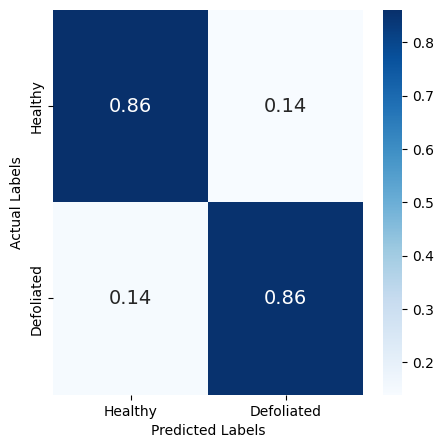

In [ ]:


cm = confusion_matrix(preds, actual, normalize='true')
df_cm = pd.DataFrame(cm, index = ['Healthy', 'Defoliated'], 
                     columns = ['Healthy', 'Defoliated'])

plt.figure(figsize=(5, 5))
s = sns.heatmap(df_cm, annot=True, cmap="Blues", 
            annot_kws={
                'fontsize': 14
            })
s.set(xlabel='Predicted Labels', ylabel='Actual Labels')

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


In [ ]:
#For fully trained

print(f1_score(actual, preds, average="binary"))
print(precision_score(actual, preds, average="binary"))
print(recall_score(actual, preds, average="binary"))  

0.8605524011163507
0.8552027543993879
0.8659693976370327


In [ ]:
preds_conv, actual_conv = test(model_conv, dataloaders, device)
preds_conv

Testing Accuracy: 0.795


array([0, 0, 1, ..., 1, 1, 1])

[Text(0.5, 25.722222222222214, 'Predicted Labels'),
 Text(33.222222222222214, 0.5, 'Actual Labels')]

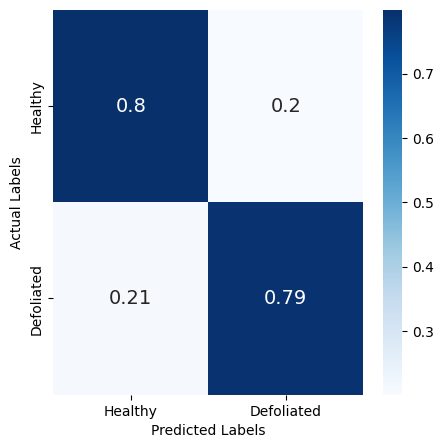

In [ ]:
#For fine tuned on conv net only
cm = confusion_matrix(preds_conv, actual_conv, normalize='true')
df_cm = pd.DataFrame(cm, index = ['Healthy', 'Defoliated'], 
                     columns = ['Healthy', 'Defoliated'])

plt.figure(figsize=(5, 5))
s = sns.heatmap(df_cm, annot=True, cmap="Blues", 
            annot_kws={
                'fontsize': 14
            })
s.set(xlabel='Predicted Labels', ylabel='Actual Labels')

In [ ]:
#Fine tuning on conv net

print(f1_score(actual_conv, preds_conv, average="binary"))
print(precision_score(actual_conv, preds_conv, average="binary"))
print(recall_score(actual_conv, preds_conv, average="binary"))  

0.796938577795001
0.7905054776090716
0.8034772416487596


WITHOUT PRETRAINING


In [ ]:
model_wo_pt = models.resnet50(pretrained=False)
num_ftrs = model_wo_pt.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
from collections import OrderedDict

model_wo_pt.fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_ftrs, 1024)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(1024, 512)),
    ('relu', nn.ReLU()),
    ('fc3', nn.Linear(512, 256)),
    ('relu', nn.ReLU()),
    ('fc4', nn.Linear(256,2))    
]))


model_wo_pt = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_wo_pt = optim.SGD(model_wo_pt.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_wo_pt, step_size=2, gamma=0.05)


In [ ]:
model_wo_pt = train_model(model_wo_pt, criterion, optimizer_wo_pt, exp_lr_scheduler,
                       num_epochs=6)

In [ ]:
model_wo_pt.class_to_idx = dataloaders['train'].dataset.class_to_idx
model_wo_pt.epochs = 6
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 2,
                  'state_dict': model_wo_pt.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer_wo_pt.state_dict(),
                  'class_to_idx': model_wo_pt.class_to_idx,
                  'epoch': model_wo_pt.epochs}
torch.save(checkpoint, '/content/drive/MyDrive/Saved Models/soyabean_resnet50_wo_pt6.pth')